In [1]:
import ot
import numpy as np
import matplotlib.pyplot as plt

import torch

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid


/Users/muz1lee/opt/anaconda3/lib/python3.9/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [2]:
device = 'cpu'

In [3]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

In [4]:
src_dataset = datasets.MNIST(root='/Users/muz1lee/Desktop/代码/FedOT/data', train=True, transform=T, download=True)
src_loader = torch.utils.data.DataLoader(dataset=src_dataset, batch_size=256, shuffle=True)

In [5]:
for xs, ys in src_loader: break

/Users/muz1lee/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Source Labels: tensor([[7, 1, 7, 6, 3, 8, 0, 0],
        [3, 0, 2, 5, 7, 0, 2, 5],
        [7, 8, 4, 0, 5, 8, 8, 0],
        [3, 9, 7, 1, 3, 5, 1, 7],
        [8, 2, 5, 7, 4, 9, 8, 8],
        [1, 2, 9, 9, 8, 7, 3, 3],
        [8, 4, 8, 8, 4, 9, 4, 1],
        [3, 1, 3, 8, 6, 3, 7, 9]])


(-0.5, 273.5, 273.5, -0.5)

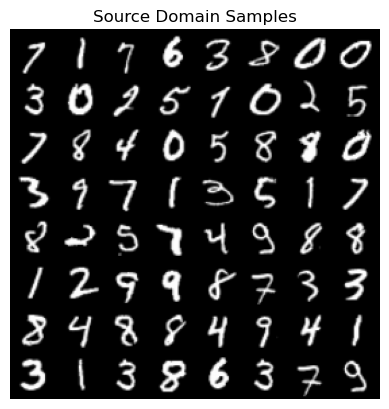

In [6]:
fig = plt.plot(figsize=(10, 5))

ind = np.random.choice(np.arange(len(xs)), size=64)
samples = xs[ind]
grid = make_grid(samples).numpy().transpose([1, 2, 0])
print('Source Labels: {}'.format(ys[ind].reshape(8, 8)))

plt.title('Source Domain Samples')
plt.imshow(grid)
plt.axis('off')

# plt.imshow(make_grid(samples[0]).numpy().transpose([1, 2, 0])) single number

In [5]:
from fed.sampling import *
dataset = 'mnist'
iid = True
num_users = 5
unequal = False
def get_dataset():
    """ Returns train and test datasets and a user group which is a dict where
    the keys are the user index and the values are the corresponding data for
    each of those users.
    """

    if dataset == 'cifar':
        data_dir = '/Users/muz1lee/Desktop/代码/FedOT/data/cifar/'
        apply_transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        train_dataset = datasets.CIFAR10(data_dir, train=True, download=True,
                                       transform=apply_transform)

        test_dataset = datasets.CIFAR10(data_dir, train=False, download=True,
                                      transform=apply_transform)

        # sample training data amongst users
        if iid:
            # Sample IID user data from Mnist
            user_groups = cifar_iid(train_dataset, num_users)
        else:
            # Sample Non-IID user data from Mnist
            if unequal:
                # Chose uneuqal splits for every user
                raise NotImplementedError()
            else:
                # Chose euqal splits for every user
                user_groups = cifar_noniid(train_dataset, num_users)

    elif dataset == 'mnist' or 'fmnist':
        if dataset == 'mnist':
            data_dir = '/Users/muz1lee/Desktop/代码/FedOT/data/mnist/'
        else:
            data_dir = '/Users/muz1lee/Desktop/代码/FedOT/data/fmnist/'

        apply_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

        train_dataset = datasets.MNIST(data_dir, train=True, download=True,
                                       transform=apply_transform)

        test_dataset = datasets.MNIST(data_dir, train=False, download=True,
                                      transform=apply_transform)

        # sample training data amongst users
        if iid:
            # Sample IID user data from Mnist
            user_groups = mnist_iid(train_dataset, num_users)
        else:
            # Sample Non-IID user data from Mnist
            if unequal:
                # Chose uneuqal splits for every user
                user_groups = mnist_noniid_unequal(train_dataset, num_users)
            else:
                # Chose euqal splits for every user
                user_groups = mnist_noniid(train_dataset, num_users)

    return train_dataset, test_dataset, user_groups

In [6]:
train_dataset, test_dataset, user_groups = get_dataset()

In [7]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/muz1lee/Desktop/代码/FedOT/data/mnist/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [8]:
user_groups.keys()  # 5*12000

dict_keys([0, 1, 2, 3, 4])

In [9]:
from torch.utils.data import DataLoader, Dataset
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

trainloader = {}

In [10]:
ratio = 0.3
bs = int(12000 * ratio)
for worker in range(len(user_groups)):
    idxs = list(user_groups[worker])
    idxs_samples = idxs[:int(ratio*len(idxs))]
    trainloader[worker] = DataLoader(DatasetSplit(train_dataset, idxs),
                             batch_size=bs, shuffle=True)


In [60]:
domains = [i for i in range(num_users)]
domains

[0, 1, 2, 3, 4]

In [53]:
Xs = []
ys =[]
for user in range(num_users):
    for batch_idx, (images, labels) in enumerate(trainloader[user]):break
    re_images = np.array(images.reshape(bs,-1))
    # re_images = (re_images - np.min(re_images, axis=0)) / (np.max(re_images, axis=0) - np.min(re_images, axis=0))
    re_labels = np.array(labels)
    Xs.append(re_images)
    ys.append(re_labels)

/var/folders/s9/d_s86vl15zv_tp38vbsr1nj40000gn/T/ipykernel_1128/2751939855.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


In [216]:
cXs = np.concatenate(Xs, axis=0)
cys = np.concatenate(ys, axis=0)
cXs

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

In [217]:
from functools import partial
from msda.barycenters import sinkhorn_barycenter

numItermax = 1
reg_e_bar = 1e-2
reg_e = 1e-2
reg_cl = 1e-2
barycenter_solver = partial(sinkhorn_barycenter, numItermax=numItermax, reg=reg_e_bar, limit_max=1e+3, stopThr=1, ys=ys, ybar=cys, verbose=False)

In [219]:

from ot.da import SinkhornL1l2Transport
transport_solver = partial(SinkhornL1l2Transport, reg_e=reg_e, reg_cl=reg_cl, norm='max')

In [220]:
from msda.utils import bar_zeros_initializer
Xbar, ybar = bar_zeros_initializer(cXs,cys)

In [221]:
from ot.utils import unif
weights = unif(len(cXs))

In [222]:
mu_s = [unif(X.shape[0]) for X in Xs]
len(mu_s)

5

In [223]:
bary, couplings = barycenter_solver(mu_s=mu_s, Xs=Xs, Xbar=Xbar)

In [224]:
couplings = [coupling.T for coupling in couplings]

In [225]:
bary

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]])

In [196]:
from torch import nn
import torch.nn.functional as F

class CNNMnist(nn.Module):
    def __init__(self, num_channels,num_classes):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def test_inference(model, test_dataset):
    """ Returns the test accuracy and loss.
    """

    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    device =  'cpu'
    criterion = nn.NLLLoss().to(device)
    testloader = DataLoader(test_dataset, batch_size=128,
                            shuffle=False)

    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct/total
    return accuracy, loss

In [206]:
model = CNNMnist(num_channels = 1, num_classes = 10).to(device)

In [207]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)


In [208]:
model.train()
criterion = nn.NLLLoss().to(device)

In [210]:
for iter in range(10):
    print('------------  iteration {}  ------------'.format(iter))
    batch_loss = []
    for idx, (image, label) in enumerate(zip(bary, cys)):
        images, label = torch.Tensor(images.reshape(1,1,28,28)).to(device),torch.Tensor([label]).long().to(device)
        model.zero_grad()
        log_probs = model(images)
        loss = criterion(log_probs, label)
        loss.backward()
        optimizer.step()

        if idx % 3000 == 0:
            print(loss.item())

------------  iteration 0  ------------
2.267101287841797


KeyboardInterrupt: 

In [201]:
def test_inference(model, test_dataset):
    """ Returns the test accuracy and loss.
    """

    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    device =  'cpu'
    criterion = nn.NLLLoss().to(device)
    testloader = DataLoader(test_dataset, batch_size=128,
                            shuffle=False)

    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct/total
    return accuracy, loss

tensor(2.3121, grad_fn=<NllLossBackward0>)

In [195]:
test_inference( model, test_dataset)

(0.1135, 181.9870114326477)